# TM10007 Assignment: ADNI

In [33]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

# Import necessary functions/packages

In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy import interp
from scipy.stats import randint

# Classifiers
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.fixes import loguniform
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from collections import Counter

# Statistics
from statistics import mean
import statistics

# Some functions we will use 

In [0]:
def removezeros(X):
  '''
  Remove features with only zero's as values
  '''
  X_nozeros = X.loc[:, (X != 0).any(axis=0)]
  return X_nozeros


def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
    return num 

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Data loading and preprocessing

In [36]:
# Data loading functions
from adni.load_data import load_data 
data = load_data()
print(data.head())
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Creating vector of labels
data_no_label = data.drop(columns='label')
print(f'The number of features: {len(data_no_label.columns)}')
x = data_no_label
y = data['label']

# Check if there are NaN's
x_nan = np.isnan(x.values)
print(f'The number of found NaN is: {np.sum(x_nan)}')

# Remove features with only zero's as values
x_df = removezeros(x)
print(f'The number of features after removing zero-features: {len(x_df.columns)}')

# Get values of of the features
x = x_df.values

# Binarize the labels
y_bin = label_binarize(y,['AD','CN'])
y_bin = [i[0] for i in y_bin]
y_bin = np.array(y_bin)

                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 268 columns]
The number of samples: 855
The number of columns: 268
The number of features: 267
The number of found NaN is: 0
The number of features after removing zero-features: 263


# Feature selection with RFECV 

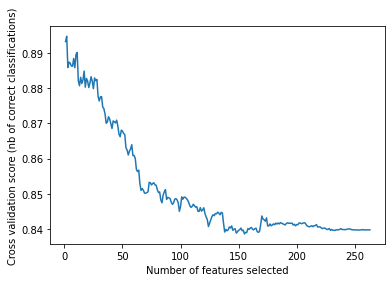

In [37]:
#For now use 1 iteration (n_splits=1) to test RFECV method
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()   #Can be changed to RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Create the RFE object and compute a cross-validated score.
    svc = SVC(kernel="linear")
    # The \"accuracy\" scoring is proportional to the number of correct classifications
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
            scoring='roc_auc')
    select = rfecv.fit(X_train_scaled, y_train)
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

#Plot explained variance for choosing a number of components for PCA


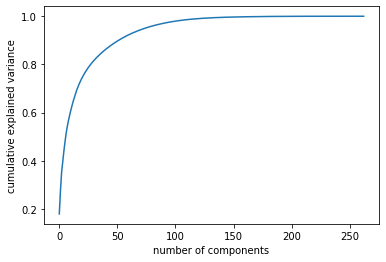

In [38]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    
    # PCA
    pca = PCA().fit(X_train_scaled)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

# RF with L1 feature selection

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.056047182489394, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.831, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


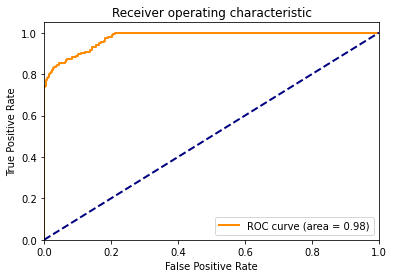

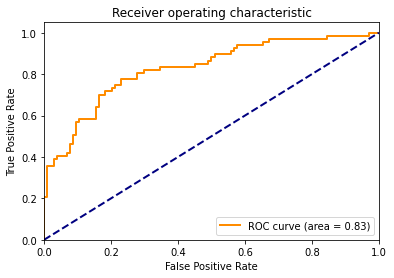

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.666349362462586, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.765, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


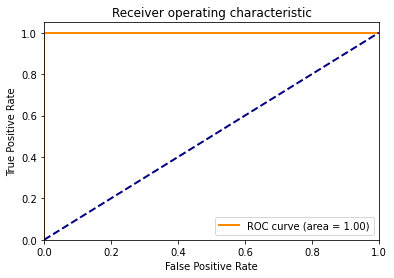

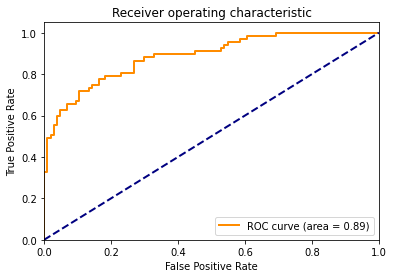

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.122188261048382, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.765, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


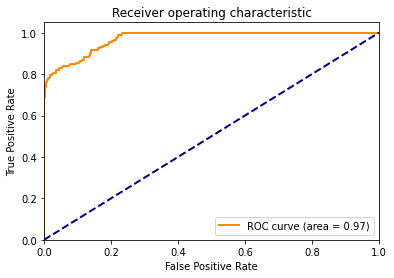

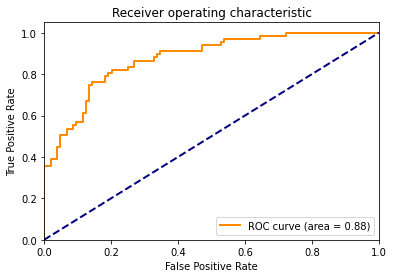

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.302525494429773, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.869, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.730, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.779, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.869, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


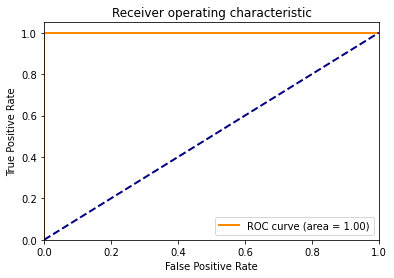

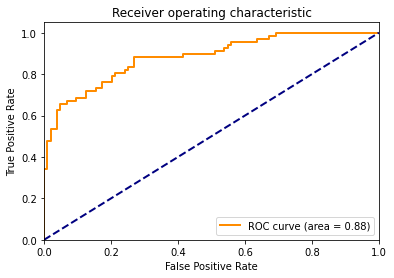

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.67614131824598, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.831, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


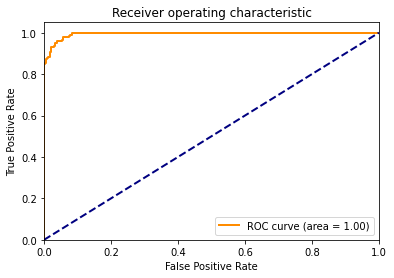

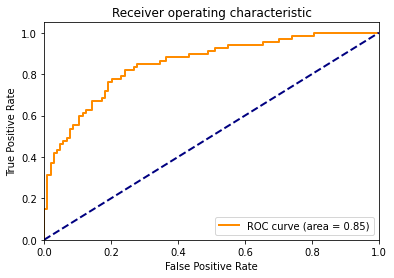

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.346864727269786, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.779, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


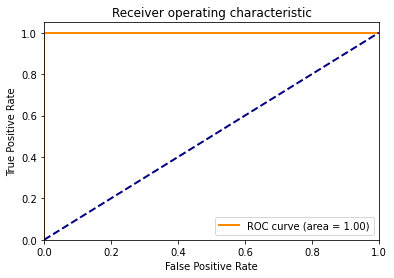

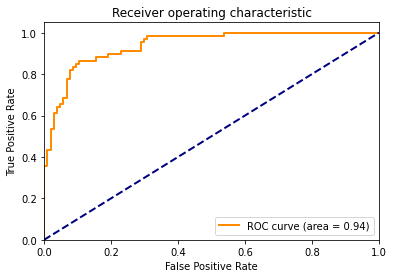

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.22027344167631, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.883, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.735, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


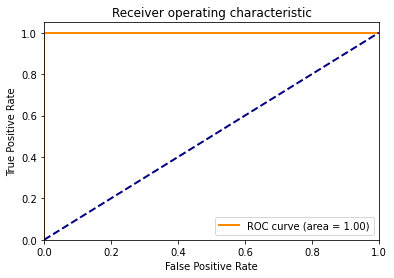

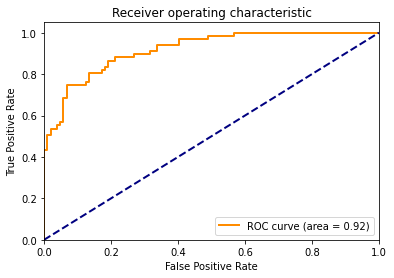

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.811852515363338, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.1s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


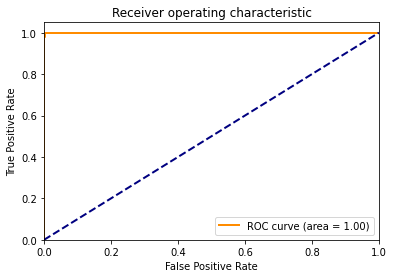

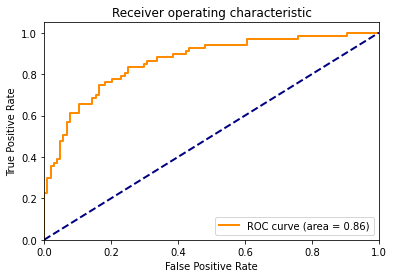

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.51536583595465, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.779, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


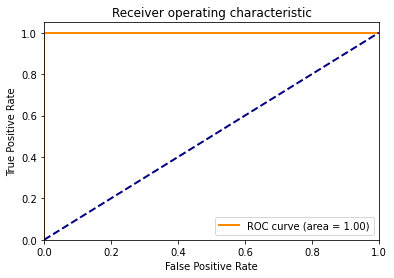

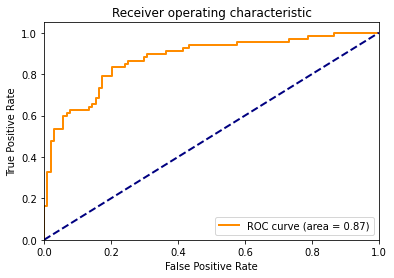

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.67720013128706, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.876, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.869, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


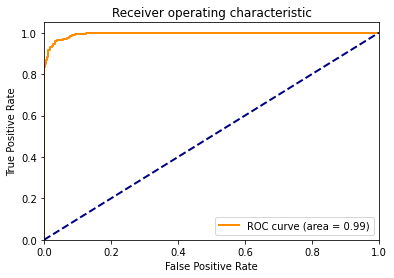

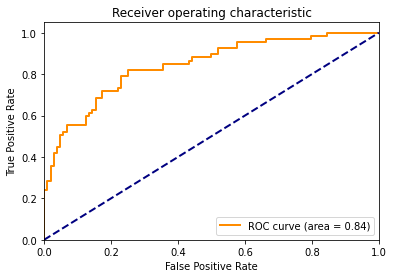

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.01419547243032, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.743, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


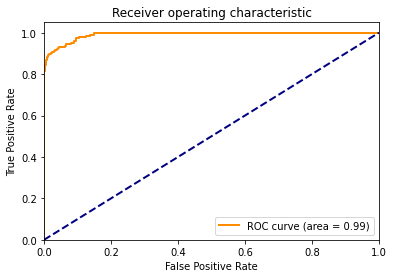

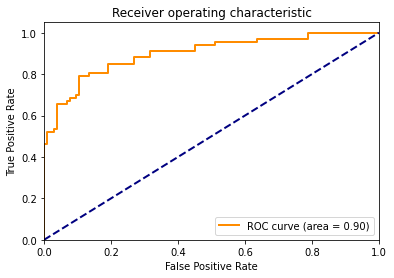

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.022784465948195, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


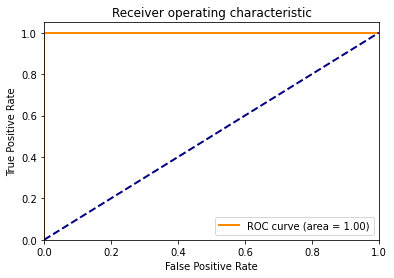

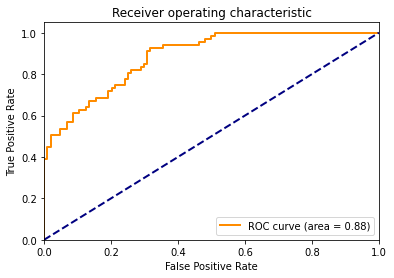

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.774382998523443, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.757, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


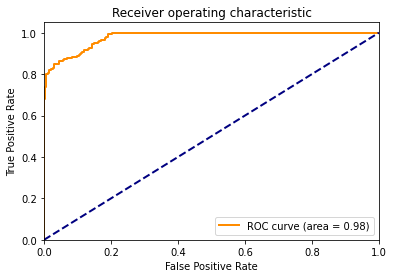

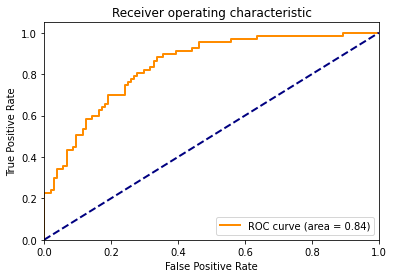

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.932754708313457, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.831, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.0s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


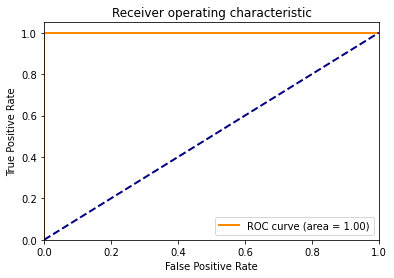

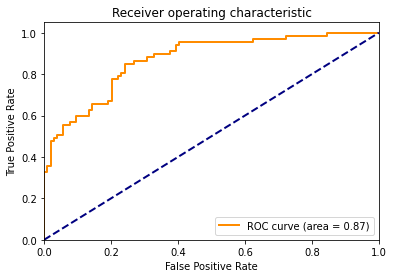

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.91971669704036, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.882, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.745, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


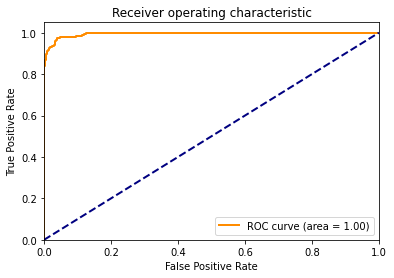

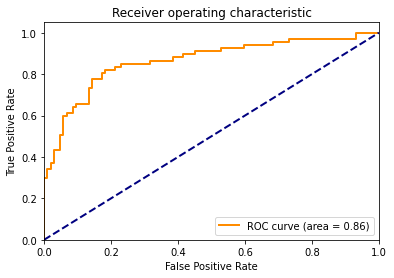

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.48094863031277, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.787, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


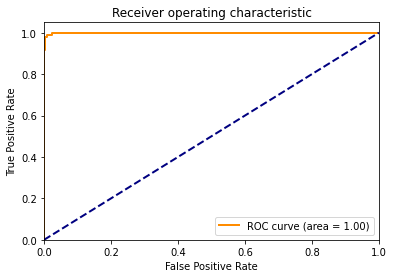

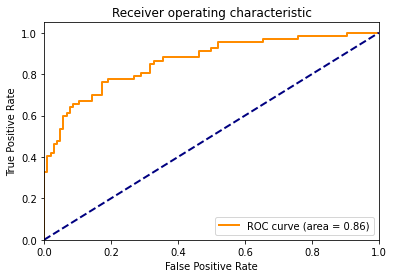

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.32789165560578, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.737, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


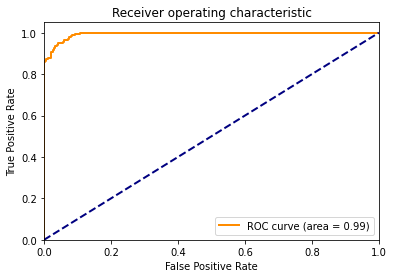

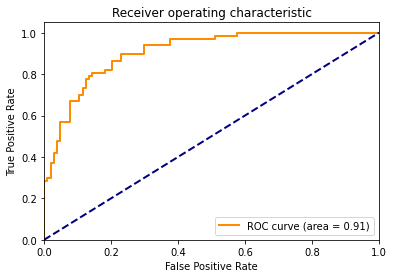

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.955204094536803, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.737, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.0s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


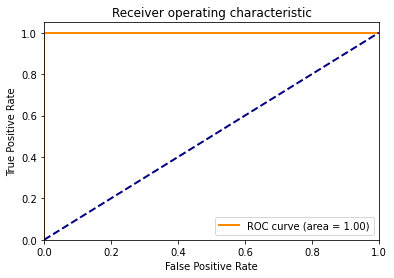

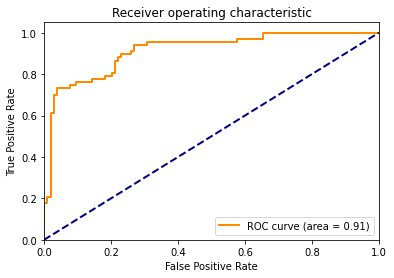

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.560869843843513, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.0s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


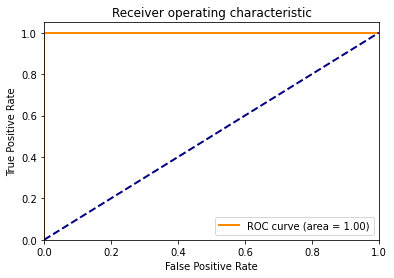

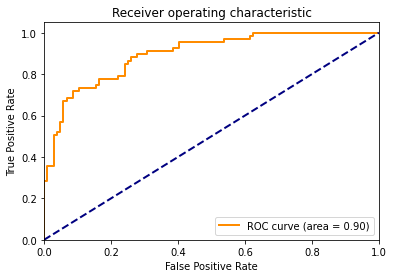

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.563233134463697, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.757, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


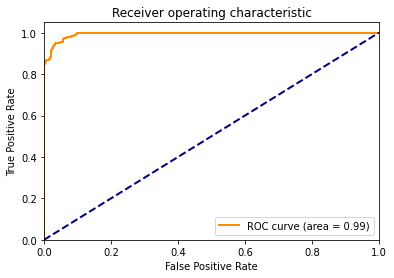

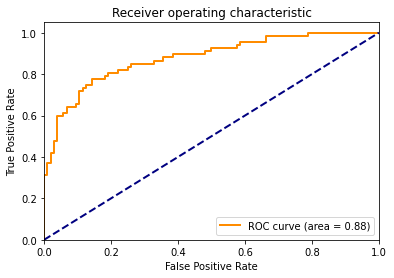

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.534172597993933, tolerance: 0.016320906432748545
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.772, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


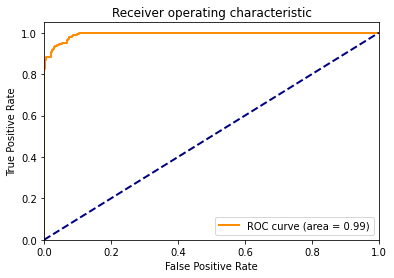

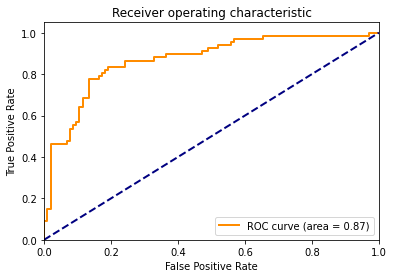

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.303767698552328, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.745, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


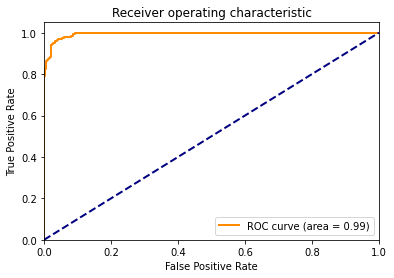

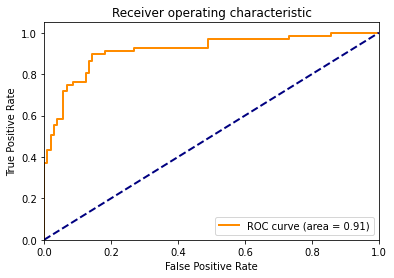

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.62260601078192, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.750, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


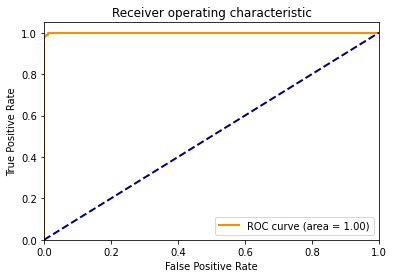

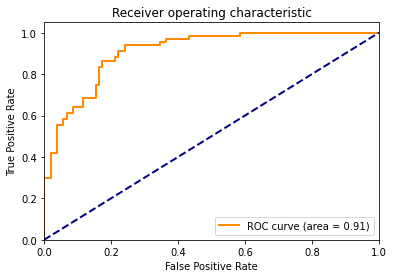

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.31765433570329, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.861, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.779, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.854, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.752, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


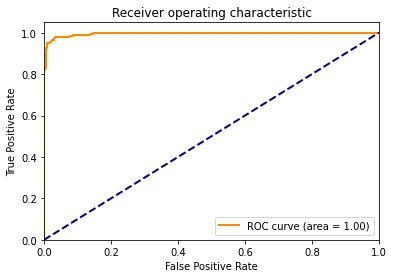

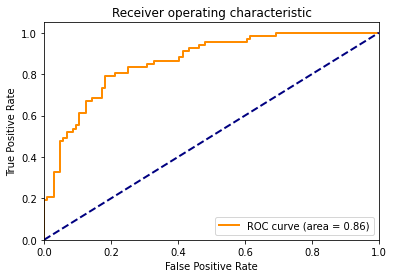

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.527753739171256, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.869, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.750, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


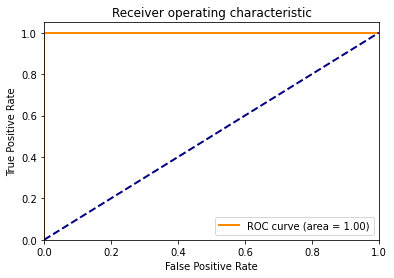

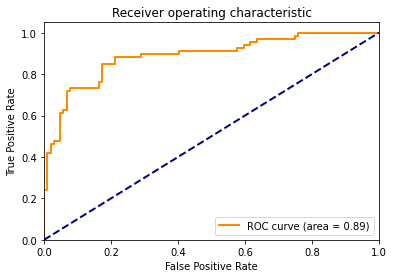

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.8690228264345, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


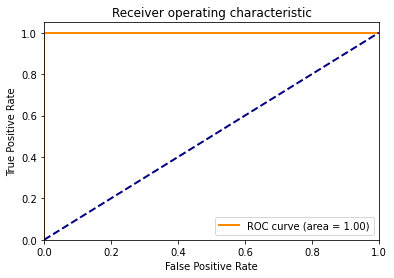

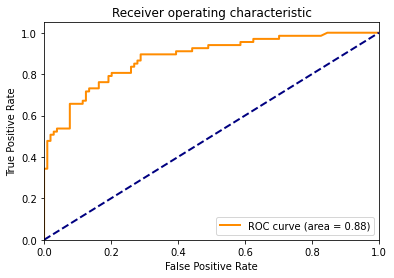

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.978074285975588, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.779, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


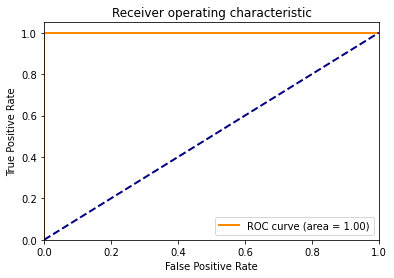

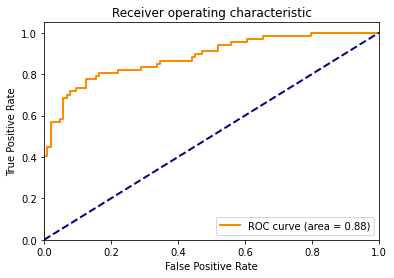

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.684918855734708, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.869, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.759, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.728, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.861, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.854, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


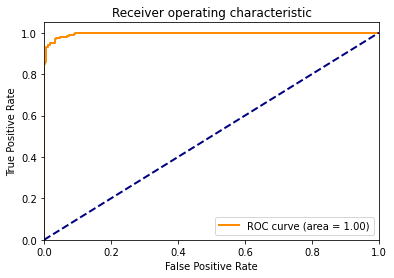

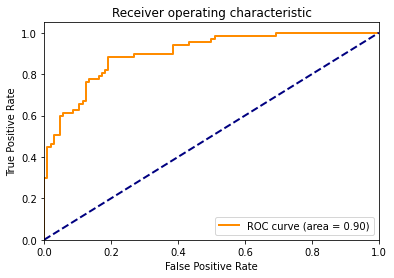

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.8532651722306, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.772, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


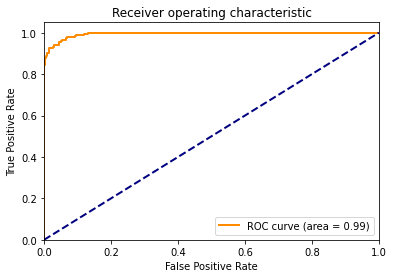

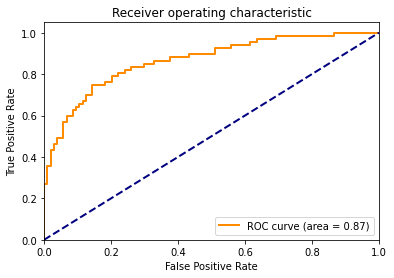

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.012490512906354, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.801, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.752, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.0s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


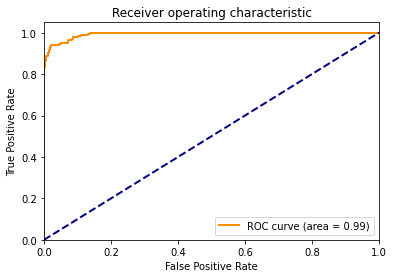

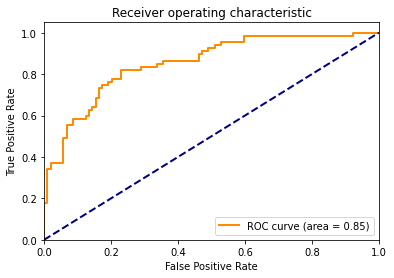

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.466985150790173, tolerance: 0.016320906432748545
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.730, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


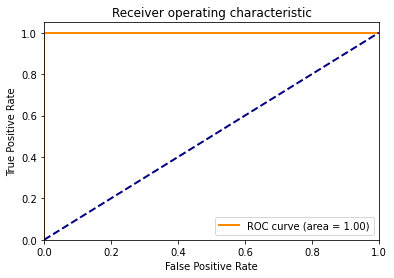

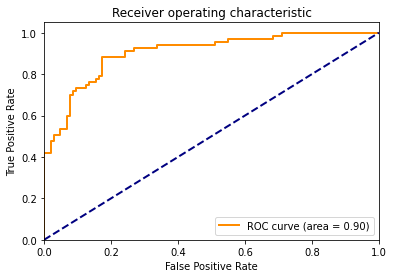

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.24801923756509, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   1.0s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.752, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.745, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


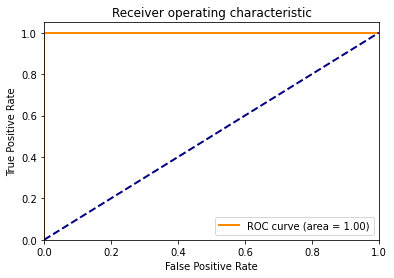

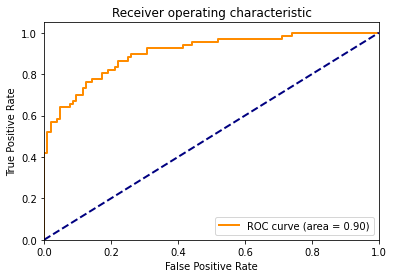

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.61178434564942, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.801, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


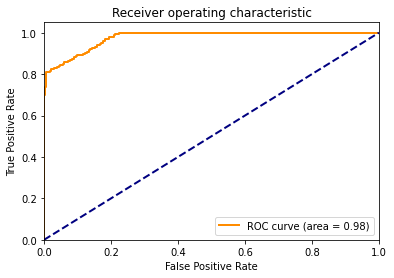

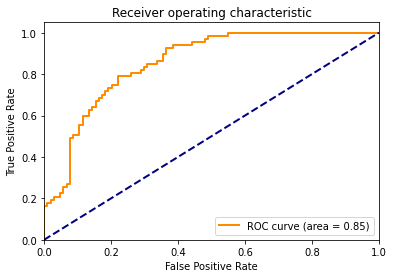

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.95900278988993, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.757, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=264,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


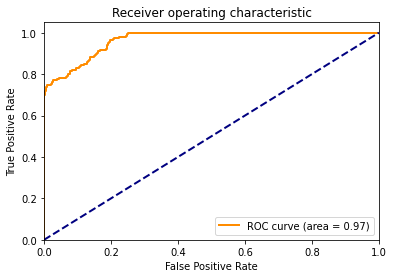

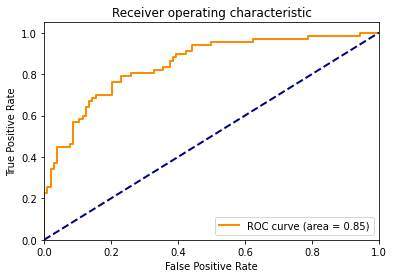

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.672408394310438, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


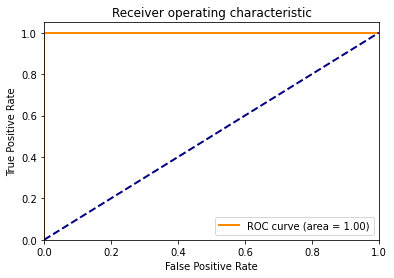

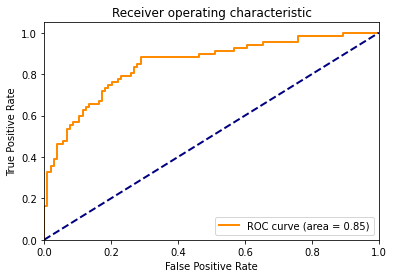

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.77818782121722, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.869, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.735, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.861, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


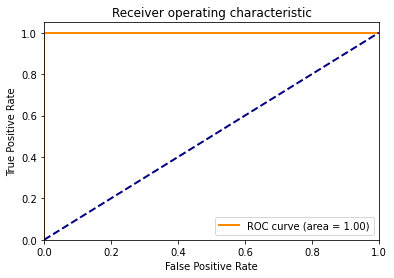

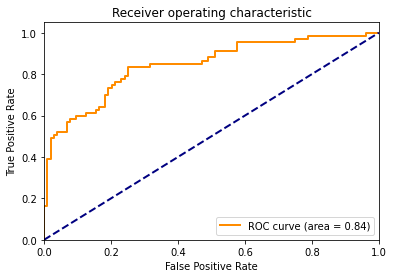

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.14390586540159, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.861, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.801, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.854, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


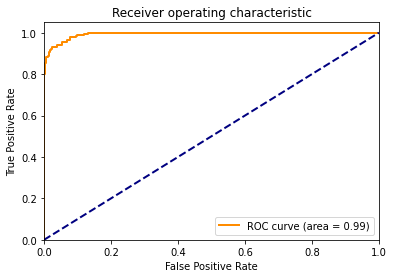

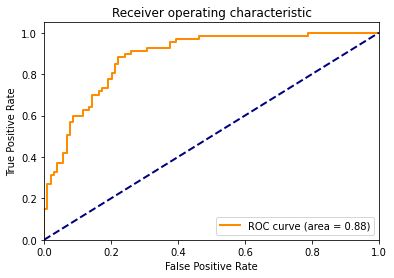

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.750423030401326, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.787, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


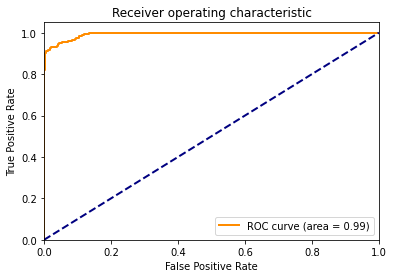

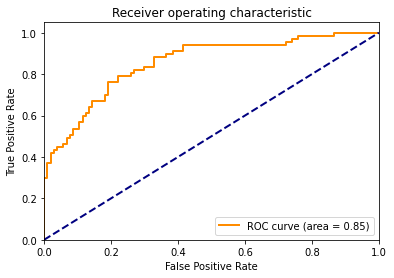

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.38174220982261, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.745, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.730, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


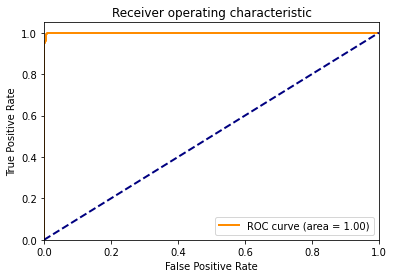

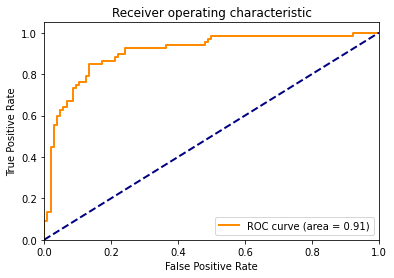

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.429916691316983, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.905, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.905, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


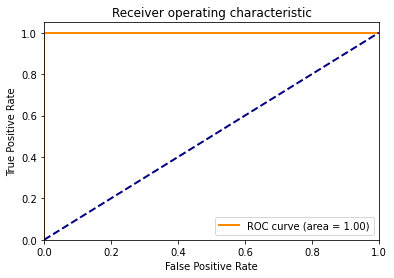

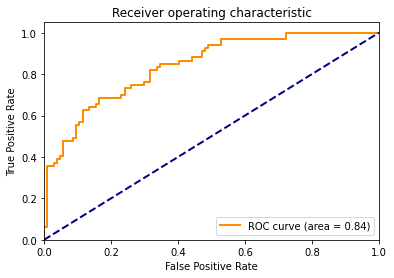

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.0233331399239, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.772, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


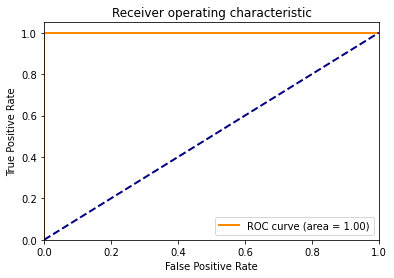

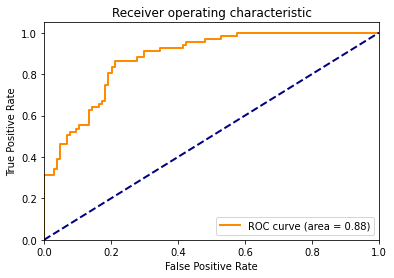

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.029639618139285, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.721, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


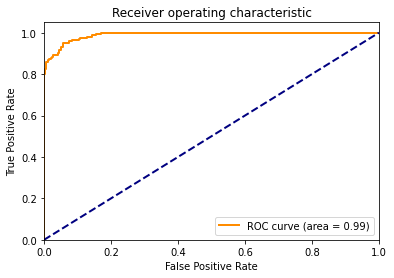

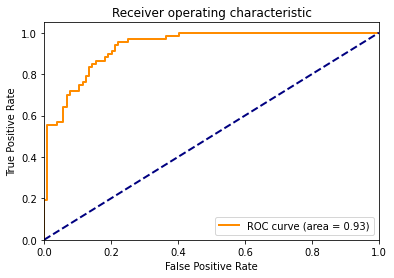

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.064802977936086, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.831, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.752, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


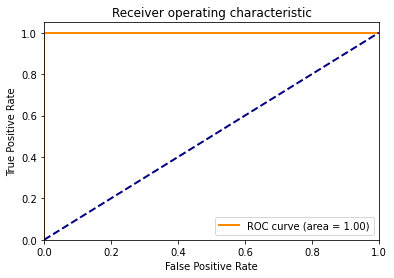

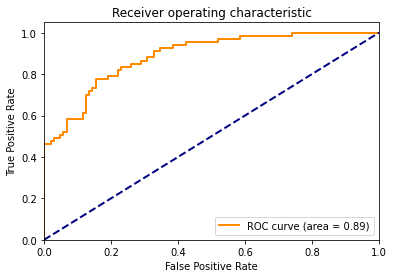

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.023770911072642, tolerance: 0.016320906432748545
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.772, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=156,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


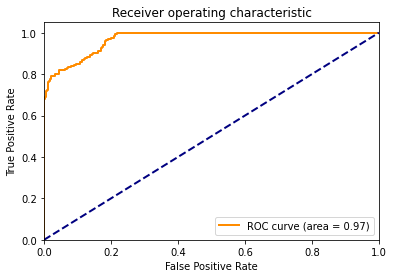

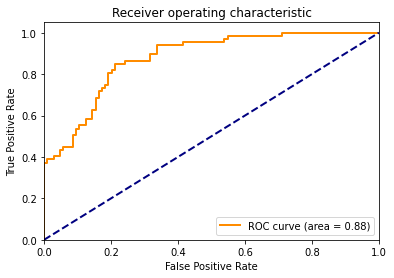

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.577291918107285, tolerance: 0.016320906432748545
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=156,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


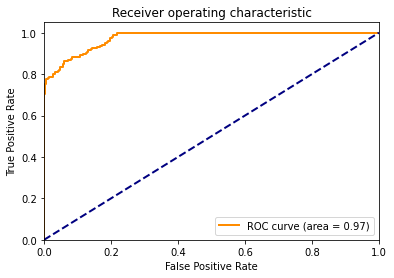

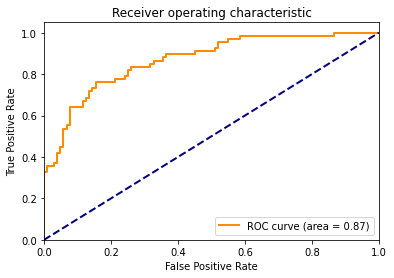

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.114790506686944, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.737, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


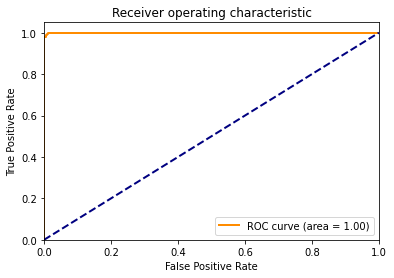

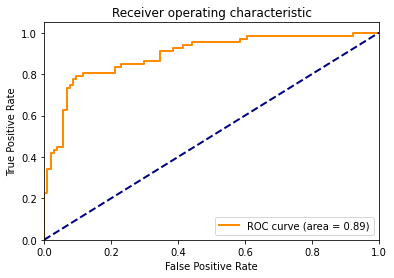

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.515463358964183, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.801, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


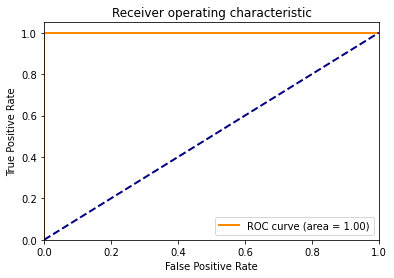

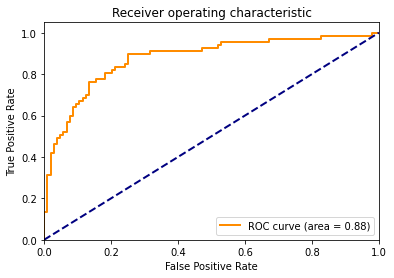

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.549033214326172, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.787, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


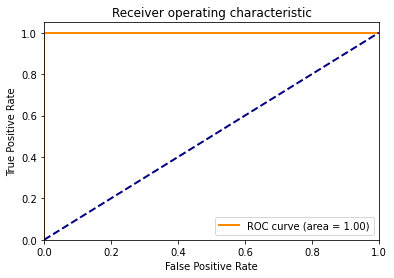

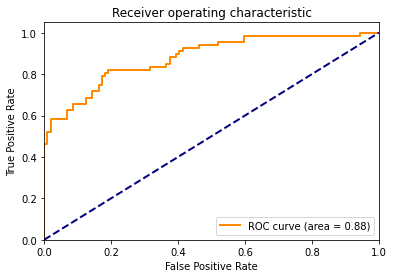

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.27228923263595, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.869, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.706, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.876, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=156,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


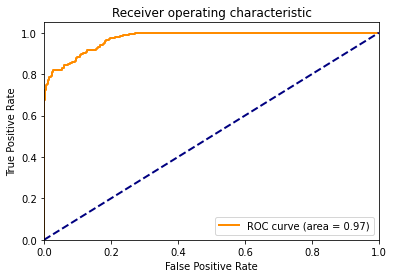

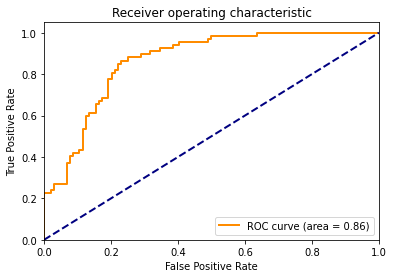

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.10224431302403, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


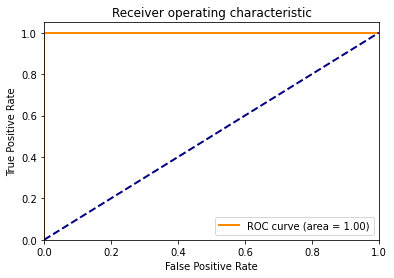

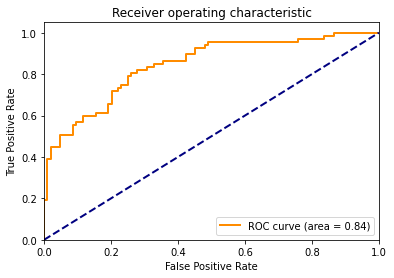

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.4941608148977, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.715, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.861, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.715, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


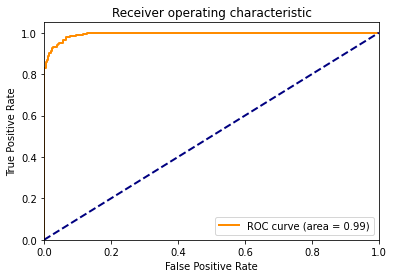

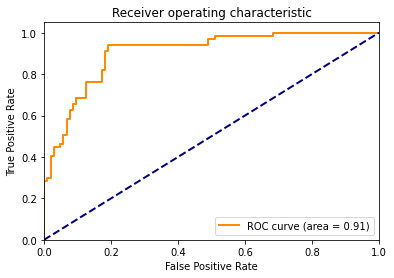

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.877846376526165, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.730, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.846, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.0s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


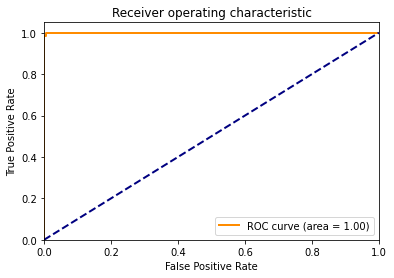

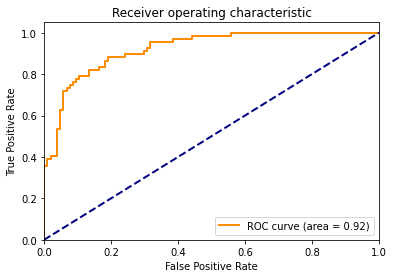

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.997455565321054, tolerance: 0.016320906432748545
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.715, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.876, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.750, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.693, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.883, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


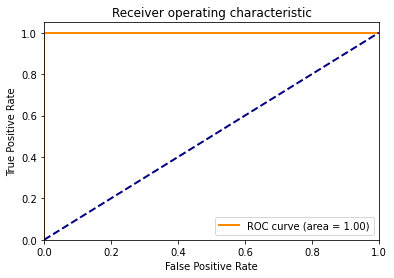

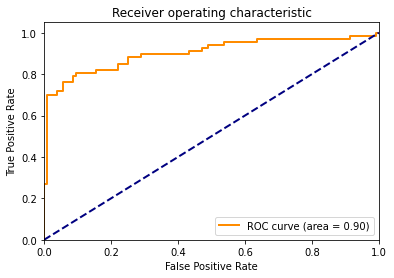

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.638073674496113, tolerance: 0.016320906432748545
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.861, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.765, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


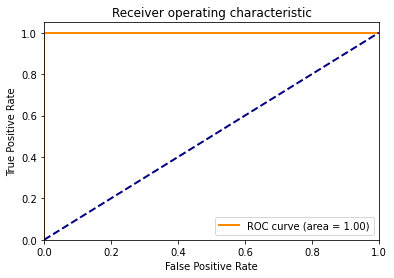

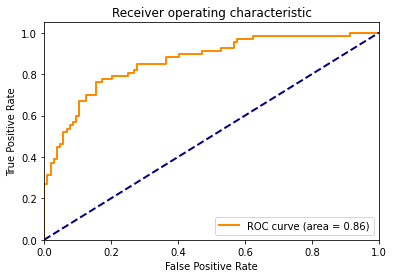

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.759372551644734, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=104,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


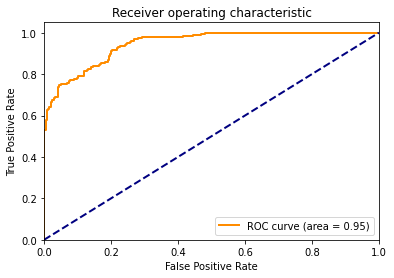

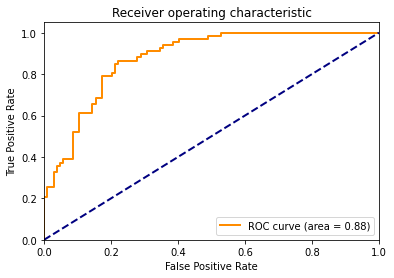

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.133304684092646, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.846, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


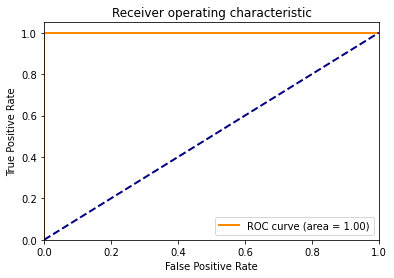

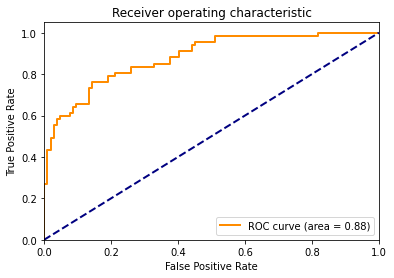

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.00328765223469, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.745, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.876, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


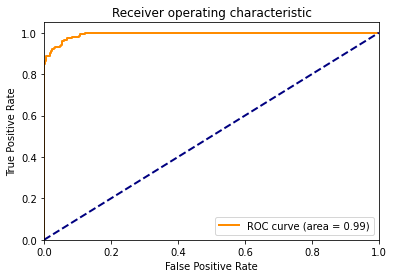

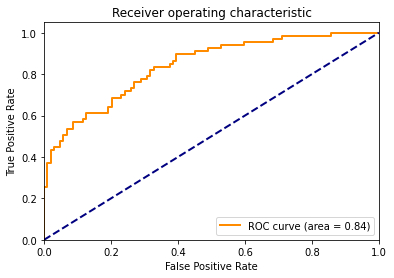

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.07370156288814, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.860, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.0s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


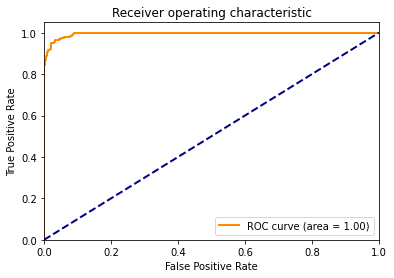

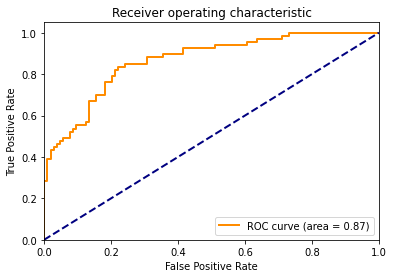

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.390415700666683, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.831, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=156,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


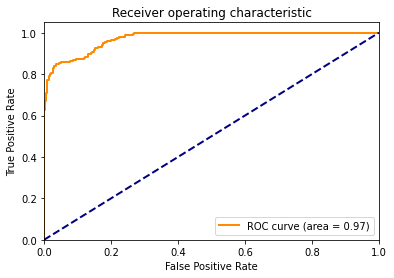

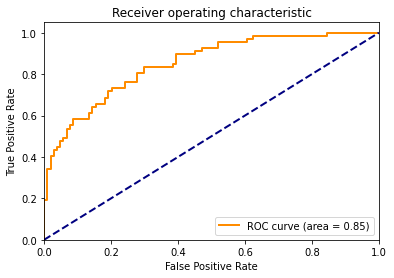

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.976730876805085, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.750, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


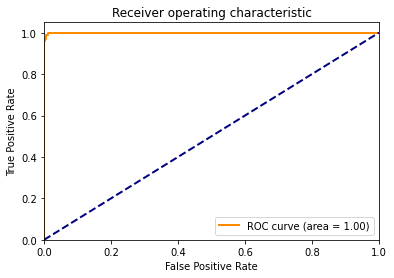

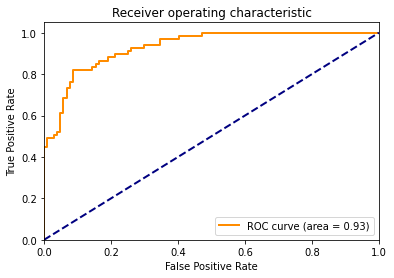

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.460941040907866, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


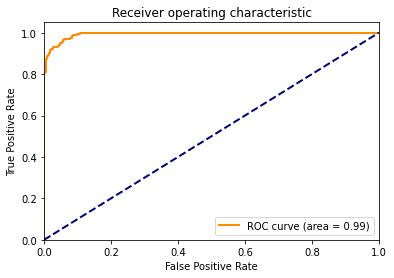

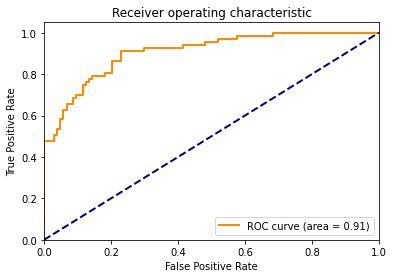

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.144442045711628, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.759, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.801, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.752, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=156,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


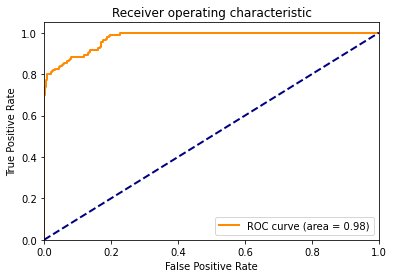

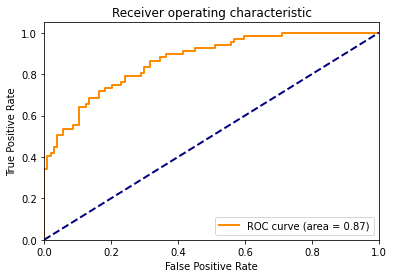

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.26252482428409, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.723, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.708, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


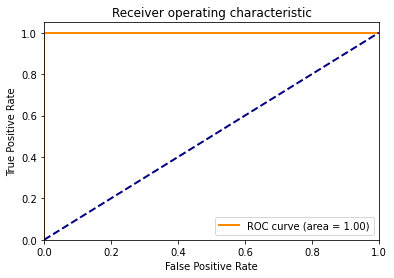

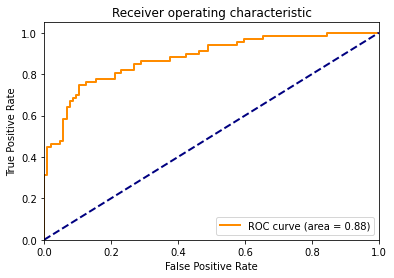

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.981065593854883, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.787, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


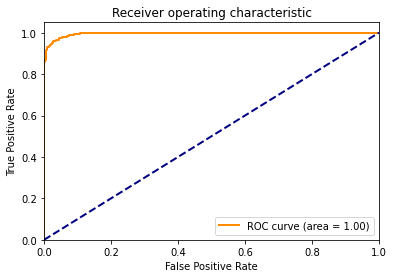

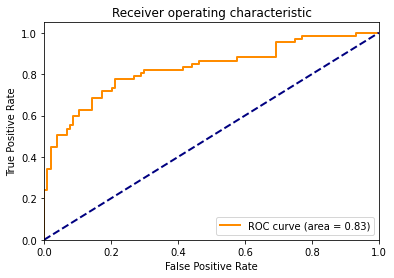

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.882475251650824, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


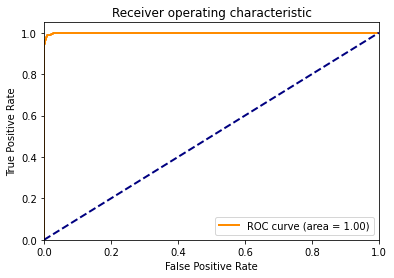

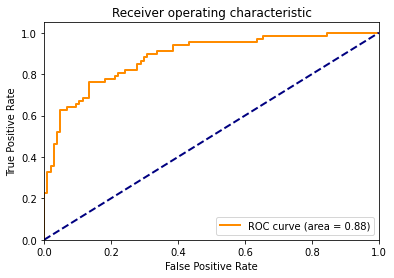

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.44433349595352, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.824, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.730, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


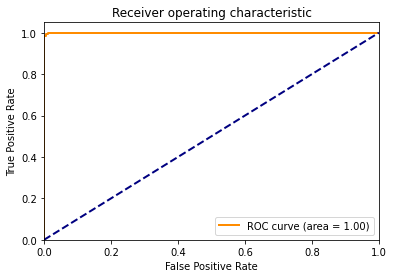

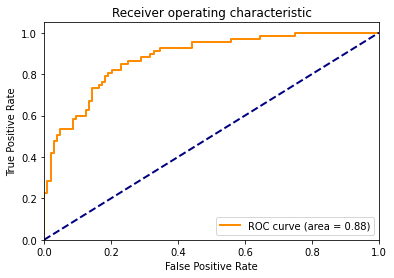

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.150099468232685, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.779, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


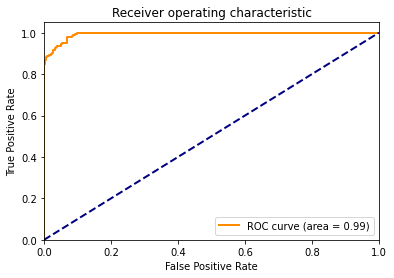

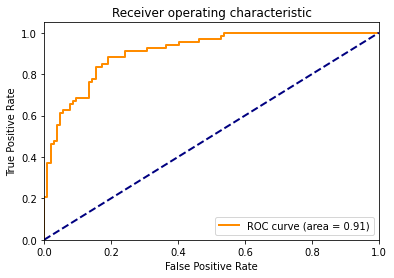

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.84228797804206, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.1s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


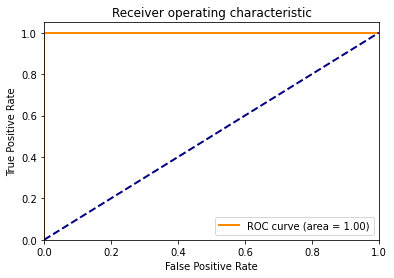

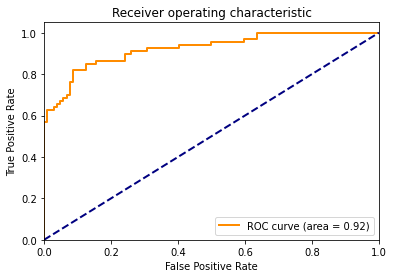

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.001407847683474, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.868, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


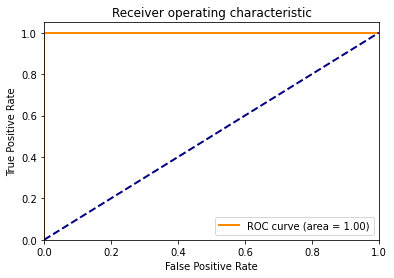

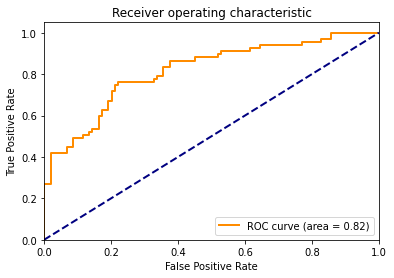

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.51262219280848, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.876, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.847, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   45.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


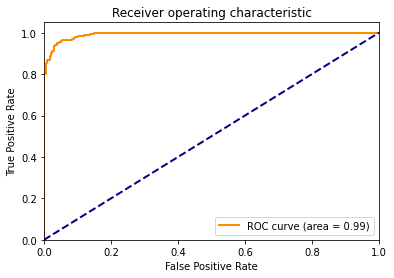

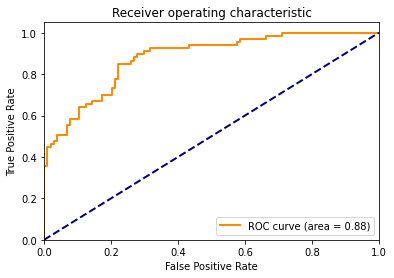

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.786380318394535, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.772, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=104,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


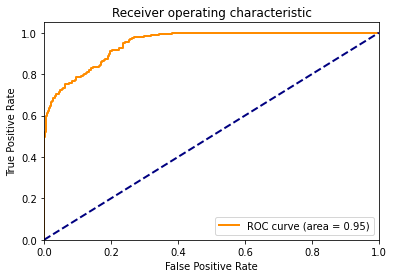

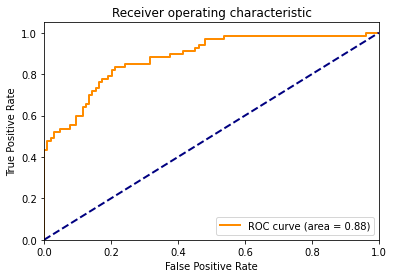

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.134034180662198, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.787, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


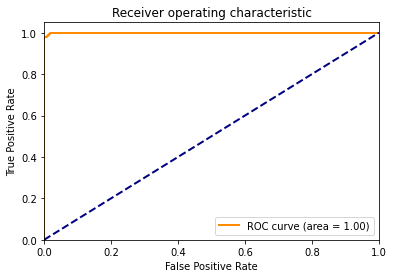

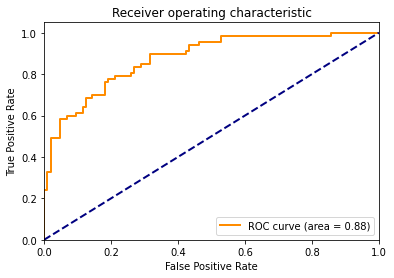

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.17041149577589, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   1.0s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.759, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.737, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.0s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


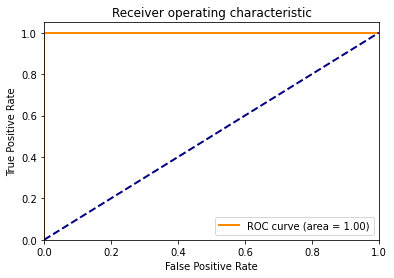

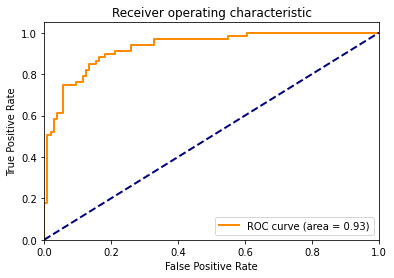

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.02370094374899, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.860, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=156,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


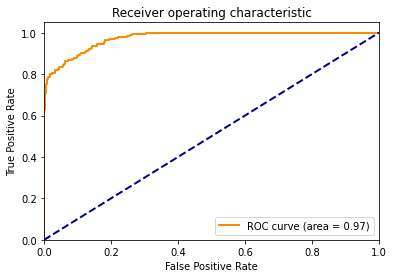

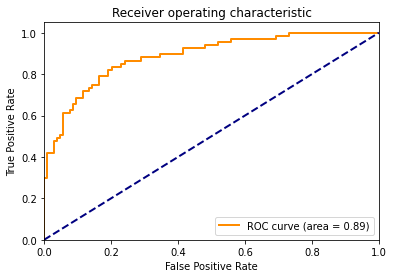

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.833087394041247, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.745, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.737, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


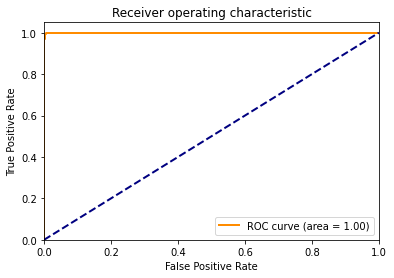

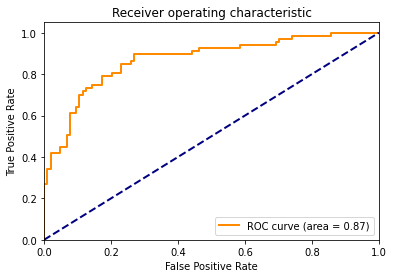

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.812663332320508, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.745, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.765, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.745, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.854, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.1s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=104,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


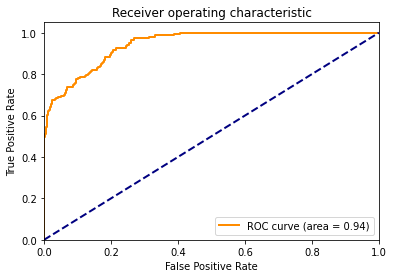

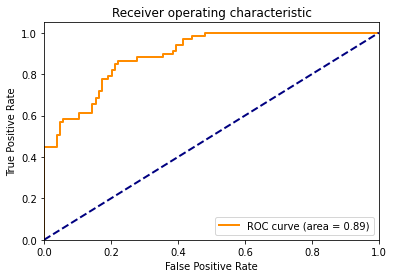

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.199491799737878, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.869, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.801, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.737, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.861, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


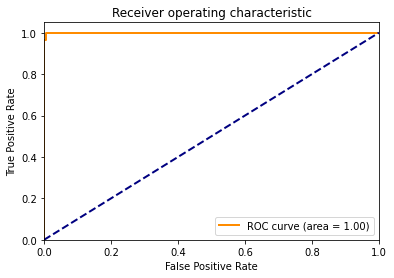

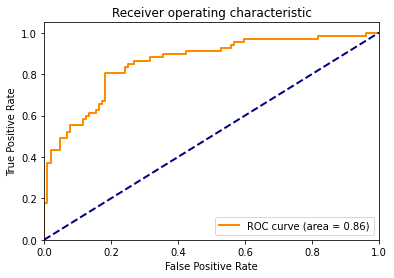

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.61603640607026, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.759, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.737, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.846, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.745, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


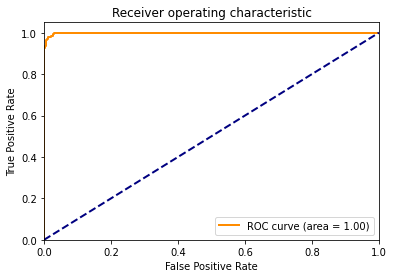

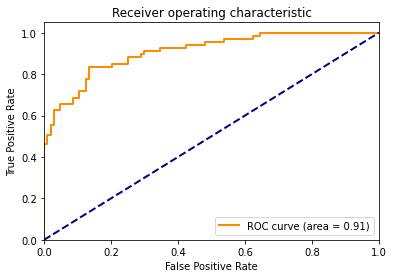

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.970606546821443, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


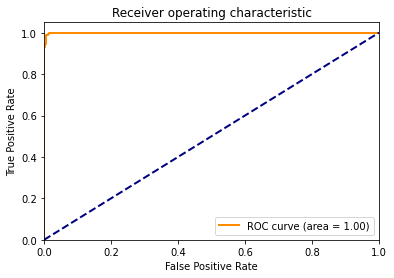

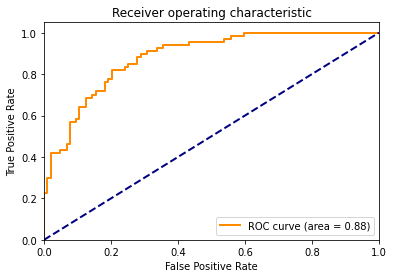

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.208453447015902, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.853, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.4s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


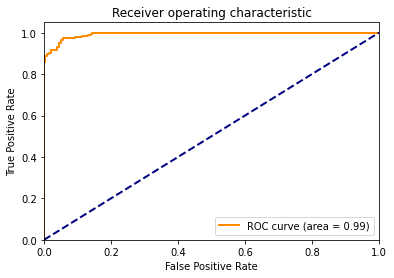

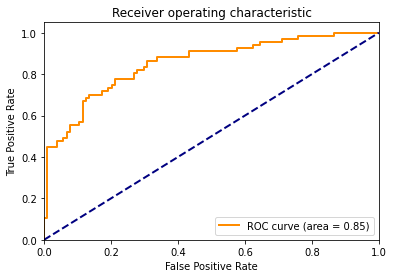

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.740373012067185, tolerance: 0.016320906432748545
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.759, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.772, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


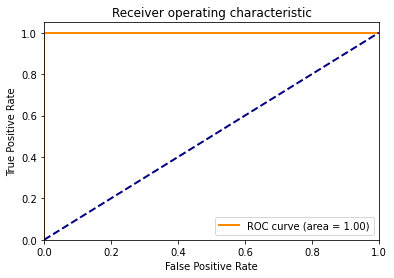

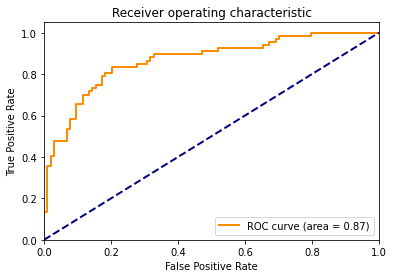

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.286809522153433, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.745, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.787, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


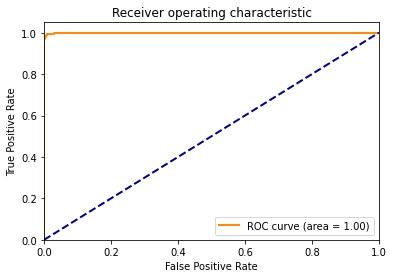

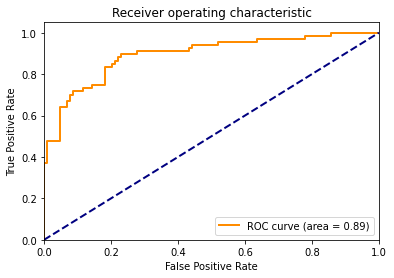

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.610751623264413, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.745, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.730, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


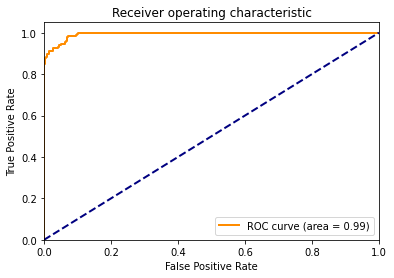

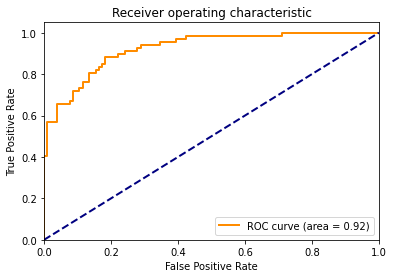

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.42368661524324, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.801, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=156,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


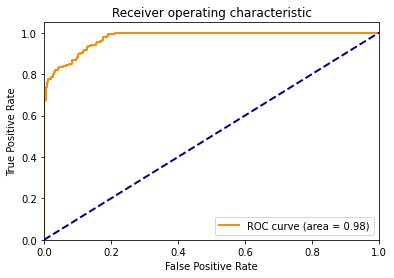

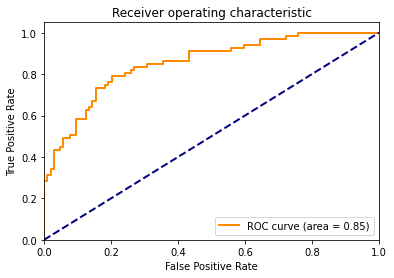

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.538338713398844, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.876, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.831, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.876, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


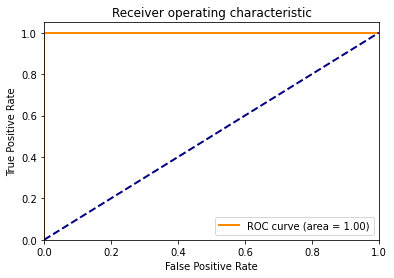

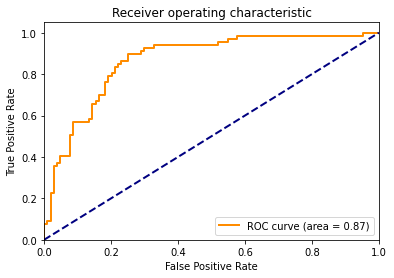

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.821821262105455, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.787, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


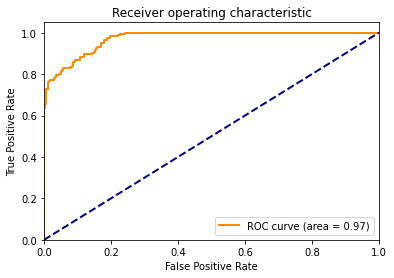

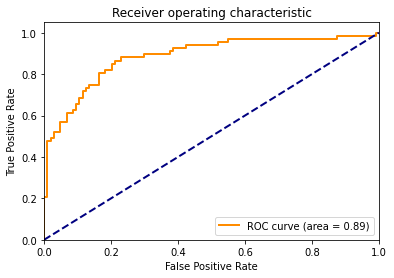

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.146797071714865, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.781, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.861, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.1s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


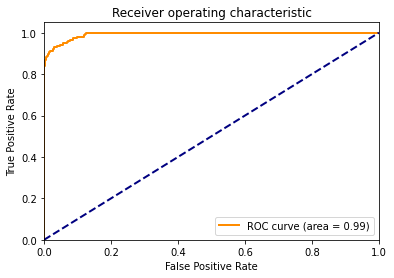

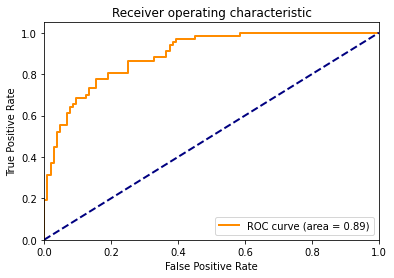

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.817679344835724, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.772, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


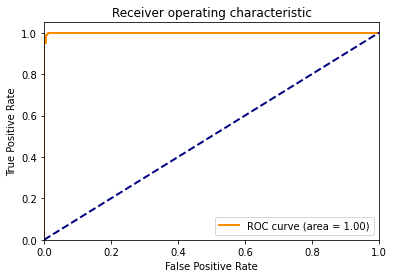

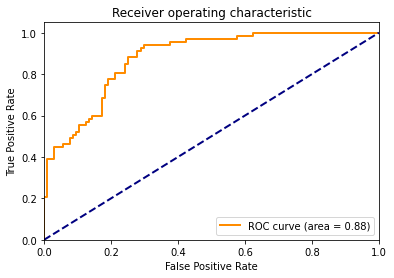

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.7416879764045, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.824, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.854, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


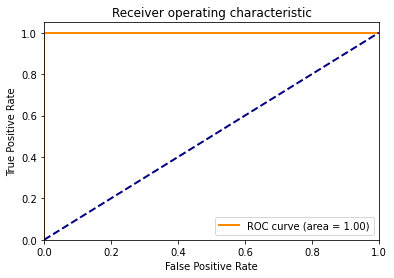

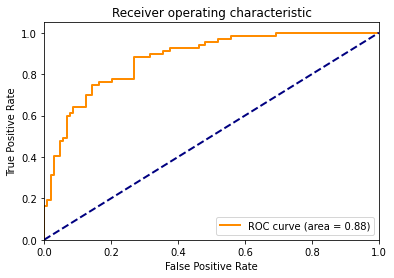

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.225532938535697, tolerance: 0.016320906432748535
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.759, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.779, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


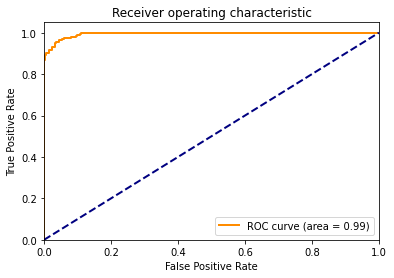

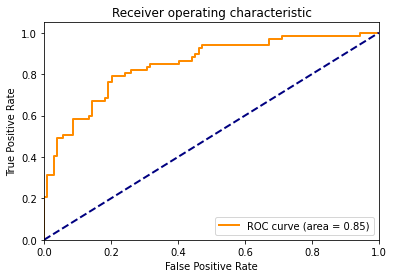

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.064424803693075, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.743, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


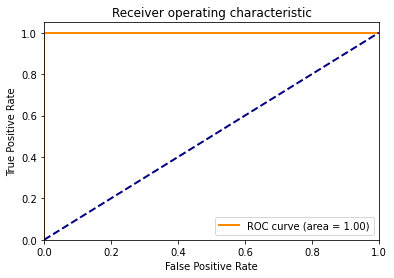

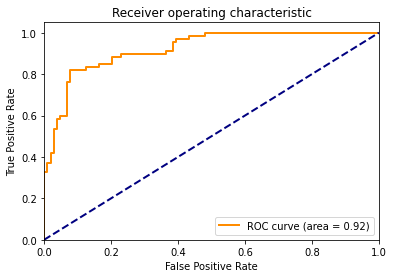

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.42939197110109, tolerance: 0.016320906432748538
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.810, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.757, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.1s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


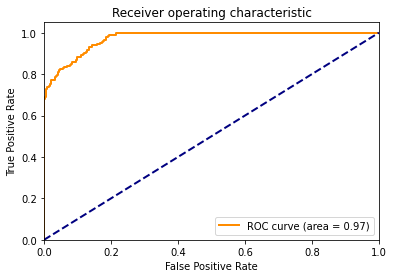

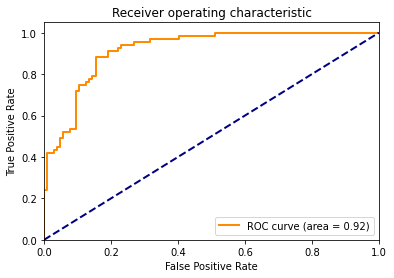

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.046696798460484, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.898, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.861, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.772, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.861, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=134,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


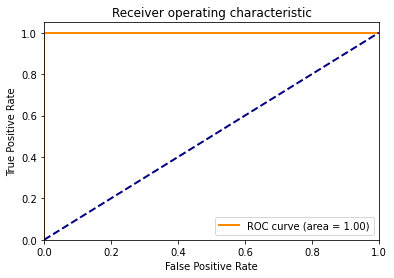

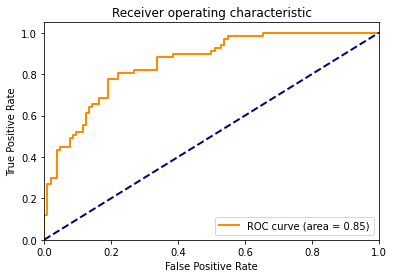

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.920644499785872, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.831, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.5s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


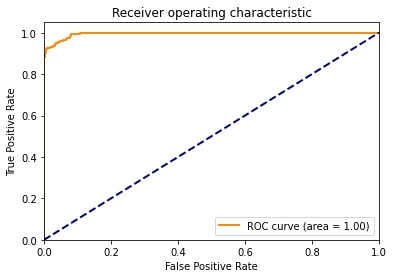

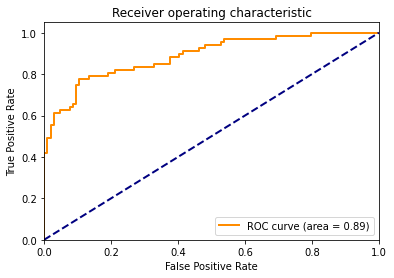

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.833324455617277, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.737, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.825, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=206,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


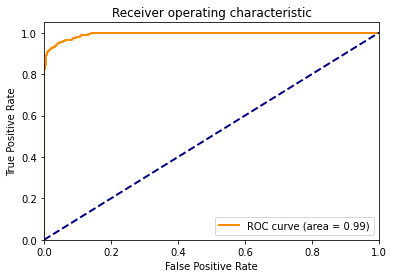

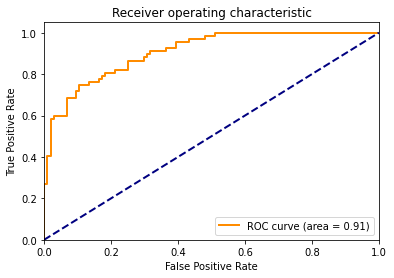

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.650083172918063, tolerance: 0.016320906432748545
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.847, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.9s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


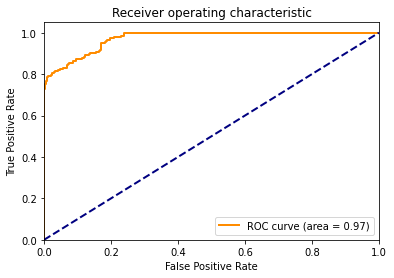

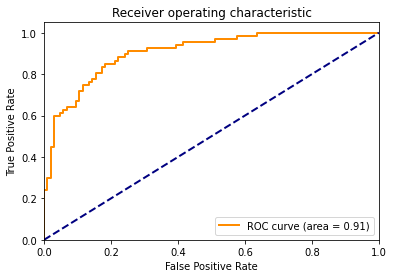

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.868230046727746, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.766, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.788, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.816, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=104,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


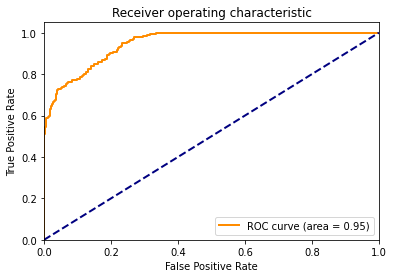

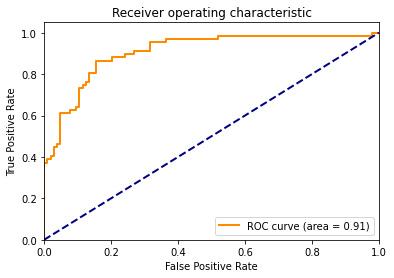

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.063252895138426, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.839, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.774, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.809, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


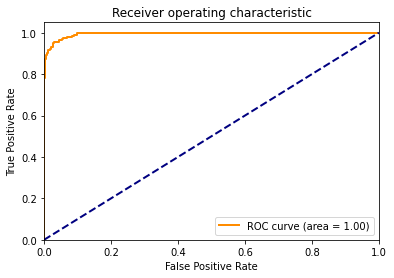

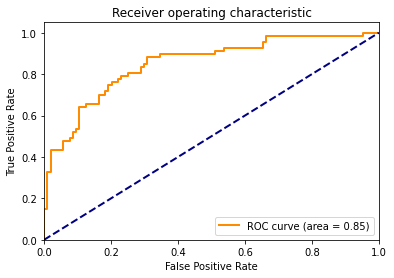

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.02717145614463, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.803, total=   0.9s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.796, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.818, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.752, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.794, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


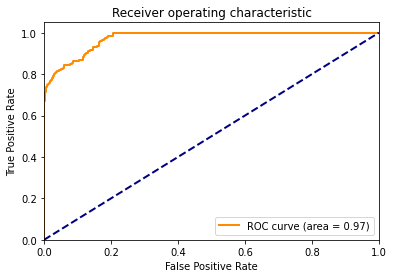

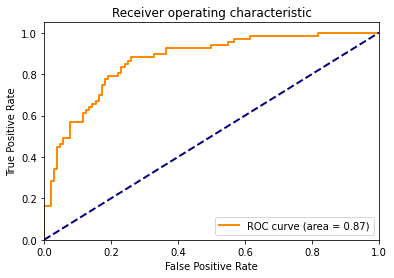

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.549457841208618, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.854, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.832, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.825, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.781, total=   0.8s
[CV] n_estimators=134, max_features=auto, max_depth=9, criterion=entropy 
[CV]  n_estimators=134, max_features=auto, max_depth=9, criterion=entropy, score=0.757, total=   0.8s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.832, total=   0.5s
[CV] n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini 
[CV]  n_estimators=156, max_features=sqrt, max_depth=5, criterion=gini, score=0.839, total=   0.5s
[CV] n_estimators=156, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.1s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


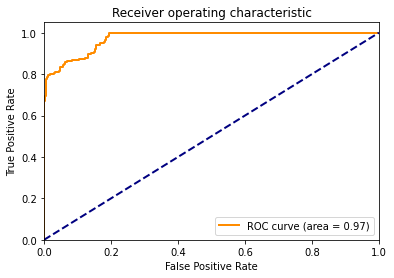

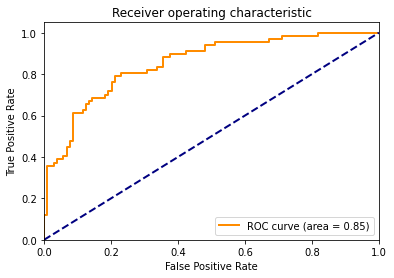

In [39]:
# Outer cross-validation, use 100 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []
best_estimator = []
best_estimator_string = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()   # RobustScaler() can also be applied 
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection - L1 method
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train)
    n_original = X_train_scaled.shape[1]
    X_train = selector.transform(X_train_scaled)
    X_test = selector.transform(X_test_scaled)
    n_selected = X_train.shape[1]
    print(f"Selected {n_selected} from {n_original} features with L1 method.")
    
    # Define hyperparameters for RF
    forest_parameters = {'n_estimators': list(range(100,301)), 
                      'criterion':  ['gini', 'entropy'],
                      'max_depth': [4, 5, 6, 7, 8, 9, 10],
                      'max_features': ['auto','sqrt','log2']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_5fold = StratifiedKFold(n_splits=5)
    grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, cv=cv_5fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)
    best_estimator.append(grid.best_estimator_)
    best_estimator_str = str(grid.best_estimator_)
    best_estimator_string.append(best_estimator_str)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

Determine what hyperparameter combination is most common and determine the accuracy.

In [40]:
# Determine which estimators is occurred most frequent in 100x cross validation
best_estimator_hyperparams = most_frequent(best_estimator_string)
print("The most common classifier is:", best_estimator_hyperparams)
print("Occurency rate of most common classifier:", best_estimator_string.count(best_estimator_hyperparams), "out of 100")
index_best_estimator_hyperparams = [i for i, e in enumerate(best_estimator_string) if e == best_estimator_hyperparams]

# Get the corresponding test accuracy scores and determine the mean and std
all_test_accuracy = np.array(test_accuracy_scores)
accuracy_best_estimator_hyperparams = []
for indices in index_best_estimator_hyperparams:
  accuracy_best_estimator_hyperparams.append(all_test_accuracy[indices])
accuracy_best_estimator_hyperparams = np.array(accuracy_best_estimator_hyperparams)
test_scores_accuracy_mean = accuracy_best_estimator_hyperparams.mean(axis=0)
test_scores_accuracy_std = accuracy_best_estimator_hyperparams.std(axis=0)

# Print results
print("The mean test accuracy score of this classifier is:", test_scores_accuracy_mean)
print("The std of the test accuracy score of this classifier is:", test_scores_accuracy_std)
print("the standard deviation for all test scores:", all_test_accuracy.std(axis=0))

The most common classifier is: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='distance')
Occurency rate of most common classifier: 23 out of 100
The mean test accuracy score of this classifier is: 0.7993897787948133
The std of the test accuracy score of this classifier is: 0.03003915076447021
the standard deviation for all test scores: 0.028642973977535235


Plot the learning curve.

KeyboardInterrupt: ignored

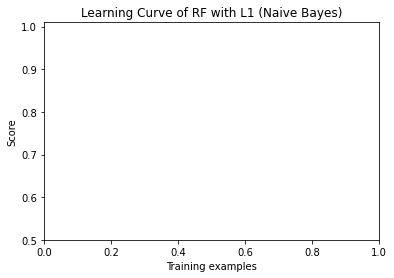

In [41]:
#Plot the learning curve of the most common classifier 
best_estimator_hyperparams_classifier = best_estimator[index_best_estimator_hyperparams[0]]
title = "Learning Curve of RF with L1 (Naive Bayes)"
cv = ShuffleSplit(x.shape[0], test_size=0.2, random_state=0)
plot_learning_curve(best_estimator_hyperparams_classifier, title, x, y_bin, ylim=(0.5, 1.01), cv=cv)
plt.show()

# RF with PCA

In [0]:
# Outer cross-validation, use 100 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []
best_estimator = []
best_estimator_string = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()   # RobustScaler() can also be applied 
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #PCA
    pca = PCA(n_components=100)
    pca = pca.fit(X_train_scaled)
    X_train = pca.transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)
    
    # Define hyperparameters for RF
    forest_parameters = {'n_estimators': list(range(100,301)), 
                      'criterion':  ['gini', 'entropy'],
                      'max_depth': [4, 5, 6, 7, 8, 9, 10],
                      'max_features': ['auto','sqrt','log2']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_5fold = StratifiedKFold(n_splits=5)
    grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, cv=cv_5fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)
    best_estimator.append(grid.best_estimator_)
    best_estimator_str = str(grid.best_estimator_)
    best_estimator_string.append(best_estimator_str)
    
    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

Determine what hyperparameter combination is most common and determine the accuracy.

In [0]:
# Determine which estimators is occurred most frequent in 100x cross validation
best_estimator_hyperparams = most_frequent(best_estimator_string)
print("The most common classifier is:", best_estimator_hyperparams)
print("Occurency rate of most common classifier:", best_estimator_string.count(best_estimator_hyperparams), "out of 100")
index_best_estimator_hyperparams = [i for i, e in enumerate(best_estimator_string) if e == best_estimator_hyperparams]

# Get the corresponding test accuracy scores and determine the mean and std
all_test_accuracy = np.array(test_accuracy_scores)
accuracy_best_estimator_hyperparams = []
for indices in index_best_estimator_hyperparams:
  accuracy_best_estimator_hyperparams.append(all_test_accuracy[indices])
accuracy_best_estimator_hyperparams = np.array(accuracy_best_estimator_hyperparams)
test_scores_accuracy_mean = accuracy_best_estimator_hyperparams.mean(axis=0)
test_scores_accuracy_std = accuracy_best_estimator_hyperparams.std(axis=0)

# Print results
print("The mean test accuracy score of this classifier is:", test_scores_accuracy_mean)
print("The std of the test accuracy score of this classifier is:", test_scores_accuracy_std)
print("the standard deviation for all test scores:", all_test_accuracy.std(axis=0))

Plot the learning curve.

In [0]:
#Plot the learning curve of the most common classifier 
best_estimator_hyperparams_classifier = best_estimator[index_best_estimator_hyperparams[0]]
title = "Learning Curve of RF with PCA (Naive Bayes)"
cv = ShuffleSplit(x.shape[0], test_size=0.2, random_state=0)
plot_learning_curve(best_estimator_hyperparams_classifier, title, x, y_bin, ylim=(0.5, 1.01), cv=cv)
plt.show()

# kNN with L1 feature selection

In [0]:
# Outer cross-validation, use 100 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []
best_estimator = []
best_estimator_string = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()   # RobustScaler() can also be applied 
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection - L1 method
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train)
    n_original = X_train_scaled.shape[1]
    X_train = selector.transform(X_train_scaled)
    X_test = selector.transform(X_test_scaled)
    n_selected = X_train.shape[1]
    print(f"Selected {n_selected} from {n_original} features with L1 method.")
    
    # Define hyperparameters for kNN
    kNN_parameters = {'n_neighbors': list(range(20,101)), 
                      'weights':  ['uniform', 'distance'],
                      'metric': ['euclidean', 'manhattan']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_5fold = StratifiedKFold(n_splits=5) 
    grid = RandomizedSearchCV(KNeighborsClassifier(), kNN_parameters, cv=cv_5fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)
    best_estimator.append(grid.best_estimator_)
    best_estimator_str = str(grid.best_estimator_)
    best_estimator_string.append(best_estimator_str)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

Determine what hyperparameter combination is most common and determine the accuracy.

In [0]:
# Determine which estimators is occurred most frequent in 100x cross validation
best_estimator_hyperparams = most_frequent(best_estimator_string)
print("The most common classifier is:", best_estimator_hyperparams)
print("Occurency rate of most common classifier:", best_estimator_string.count(best_estimator_hyperparams), "out of 100")
index_best_estimator_hyperparams = [i for i, e in enumerate(best_estimator_string) if e == best_estimator_hyperparams]

# Get the corresponding test accuracy scores and determine the mean and std
all_test_accuracy = np.array(test_accuracy_scores)
accuracy_best_estimator_hyperparams = []
for indices in index_best_estimator_hyperparams:
  accuracy_best_estimator_hyperparams.append(all_test_accuracy[indices])
accuracy_best_estimator_hyperparams = np.array(accuracy_best_estimator_hyperparams)
test_scores_accuracy_mean = accuracy_best_estimator_hyperparams.mean(axis=0)
test_scores_accuracy_std = accuracy_best_estimator_hyperparams.std(axis=0)

# Print results
print("The mean test accuracy score of this classifier is:", test_scores_accuracy_mean)
print("The std of the test accuracy score of this classifier is:", test_scores_accuracy_std)
print("the standard deviation for all test scores:", all_test_accuracy.std(axis=0))

Plot the learning curve. 


In [0]:
#Plot the learning curve of the most common classifier 
best_estimator_hyperparams_classifier = best_estimator[index_best_estimator_hyperparams[0]]
title = "Learning Curve of kNN with L1 (Naive Bayes)"
cv = ShuffleSplit(x.shape[0], test_size=0.2, random_state=0)
plot_learning_curve(best_estimator_hyperparams_classifier, title, x, y_bin, ylim=(0.5, 1.01), cv=cv)
plt.show()

# kNN with PCA

In [0]:
# Outer cross-validation, use 100 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []
best_estimator = []
best_estimator_string = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()   # RobustScaler() can also be applied 
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    pca = PCA().fit(X_train_scaled)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

    # Feature selection - PCA
    pca = PCA(n_components=100)
    pca = pca.fit(X_train_scaled)
    X_train = pca.transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)
    
    # Define hyperparameters for kNN
    kNN_parameters = {'n_neighbors': list(range(20,101)), 
                      'weights':  ['uniform', 'distance'],
                      'metric': ['euclidean', 'manhattan']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_5fold = StratifiedKFold(n_splits=5)
    grid = RandomizedSearchCV(KNeighborsClassifier(), kNN_parameters, cv=cv_5fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)
    best_estimator.append(grid.best_estimator_)
    best_estimator_str = str(grid.best_estimator_)
    best_estimator_string.append(best_estimator_str)
    
    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

Determine what hyperparameter combination is most common and determine the accuracy.

In [0]:
# Determine which estimators is occurred most frequent in 100x cross validation
best_estimator_hyperparams = most_frequent(best_estimator_string)
print("The most common classifier is:", best_estimator_hyperparams)
print("Occurency rate of most common classifier:", best_estimator_string.count(best_estimator_hyperparams), "out of 100")
index_best_estimator_hyperparams = [i for i, e in enumerate(best_estimator_string) if e == best_estimator_hyperparams]

# Get the corresponding test accuracy scores and determine the mean and std
all_test_accuracy = np.array(test_accuracy_scores)
accuracy_best_estimator_hyperparams = []
for indices in index_best_estimator_hyperparams:
  accuracy_best_estimator_hyperparams.append(all_test_accuracy[indices])
accuracy_best_estimator_hyperparams = np.array(accuracy_best_estimator_hyperparams)
test_scores_accuracy_mean = accuracy_best_estimator_hyperparams.mean(axis=0)
test_scores_accuracy_std = accuracy_best_estimator_hyperparams.std(axis=0)

# Print results
print("The mean test accuracy score of this classifier is:", test_scores_accuracy_mean)
print("The std of the test accuracy score of this classifier is:", test_scores_accuracy_std)
print("the standard deviation for all test scores:", all_test_accuracy.std(axis=0))

Plot the learning curve. 

In [0]:
#Plot the learning curve of the most common classifier 
best_estimator_hyperparams_classifier = best_estimator[index_best_estimator_hyperparams[0]]
title = "Learning Curve of kNN with PCA (Naive Bayes)"
cv = ShuffleSplit(x.shape[0], test_size=0.2, random_state=0)
plot_learning_curve(best_estimator_hyperparams_classifier, title, x, y_bin, ylim=(0.5, 1.01), cv=cv)
plt.show()

# SVM classifier with L1 feature selection

In [0]:
# Outer cross-validation, use 100 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []
best_estimator = []
best_estimator_string = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()     # RobustScaler() can also be applied
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection - L1 method
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train)
    n_original = X_train_scaled.shape[1]
    X_train = selector.transform(X_train_scaled)
    X_test = selector.transform(X_test_scaled)
    n_selected = X_train.shape[1]
    print(f"Selected {n_selected} from {n_original} features with L1 method.")
    
    # Define hyperparameters for SVM 
    SVM_param = {'C': [1, 5, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01], 
                  'kernel': ['rbf','poly', 'linear']}  

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_5fold = StratifiedKFold(n_splits=5)
    grid = RandomizedSearchCV(SVC(probability=True), SVM_param, cv=cv_5fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)
    best_estimator.append(grid.best_estimator_)
    best_estimator_str = str(grid.best_estimator_)
    best_estimator_string.append(best_estimator_str)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

Determine what hyperparameter combination is most common and determine the accuracy.

In [0]:
# Determine which estimators is occurred most frequent in 100x cross validation
best_estimator_hyperparams = most_frequent(best_estimator_string)
print("The most common classifier is:", best_estimator_hyperparams)
print("Occurency rate of most common classifier:", best_estimator_string.count(best_estimator_hyperparams), "out of 100")
index_best_estimator_hyperparams = [i for i, e in enumerate(best_estimator_string) if e == best_estimator_hyperparams]

# Get the corresponding test accuracy scores and determine the mean and std
all_test_accuracy = np.array(test_accuracy_scores)
accuracy_best_estimator_hyperparams = []
for indices in index_best_estimator_hyperparams:
  accuracy_best_estimator_hyperparams.append(all_test_accuracy[indices])
accuracy_best_estimator_hyperparams = np.array(accuracy_best_estimator_hyperparams)
test_scores_accuracy_mean = accuracy_best_estimator_hyperparams.mean(axis=0)
test_scores_accuracy_std = accuracy_best_estimator_hyperparams.std(axis=0)

# Print results
print("The mean test accuracy score of this classifier is:", test_scores_accuracy_mean)
print("The std of the test accuracy score of this classifier is:", test_scores_accuracy_std)
print("the standard deviation for all test scores:", all_test_accuracy.std(axis=0))

Plot the learning curve.

In [0]:
#Plot the learning curve of the most common classifier 
best_estimator_hyperparams_classifier = best_estimator[index_best_estimator_hyperparams[0]]
title = "Learning Curve of SVM with L1 (Naive Bayes)"
cv = ShuffleSplit(x.shape[0], test_size=0.2, random_state=0)
plot_learning_curve(best_estimator_hyperparams_classifier, title, x, y_bin, ylim=(0.5, 1.01), cv=cv)
plt.show()

# SVM classifier with PCA

In [0]:
# Outer cross-validation, use 100 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []
best_estimator = []
best_estimator_string = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()   # RobustScaler() can also be applied
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #PCA
    pca = PCA(n_components=100)
    pca = pca.fit(X_train_scaled)
    X_train = pca.transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)
    
    # Define hyperparameters for SVM 
    SVM_param = {'C': [1, 5, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01], 
                  'kernel': ['rbf','poly', 'linear']}   

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_5fold = StratifiedKFold(n_splits=5)
    grid = RandomizedSearchCV(SVC(probability=True), SVM_param, cv=cv_5fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)
    best_estimator.append(grid.best_estimator_)
    best_estimator_str = str(grid.best_estimator_)
    best_estimator_string.append(best_estimator_str)
    
    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

Determine what hyperparameter combination is most common and determine the accuracy.

In [0]:
# Determine which estimators is occurred most frequent in 100x cross validation
best_estimator_hyperparams = most_frequent(best_estimator_string)
print("The most common classifier is:", best_estimator_hyperparams)
print("Occurency rate of most common classifier:", best_estimator_string.count(best_estimator_hyperparams), "out of 100")
index_best_estimator_hyperparams = [i for i, e in enumerate(best_estimator_string) if e == best_estimator_hyperparams]

# Get the corresponding test accuracy scores and determine the mean and std
all_test_accuracy = np.array(test_accuracy_scores)
accuracy_best_estimator_hyperparams = []
for indices in index_best_estimator_hyperparams:
  accuracy_best_estimator_hyperparams.append(all_test_accuracy[indices])
accuracy_best_estimator_hyperparams = np.array(accuracy_best_estimator_hyperparams)
test_scores_accuracy_mean = accuracy_best_estimator_hyperparams.mean(axis=0)
test_scores_accuracy_std = accuracy_best_estimator_hyperparams.std(axis=0)

# Print results
print("The mean test accuracy score of this classifier is:", test_scores_accuracy_mean)
print("The std of the test accuracy score of this classifier is:", test_scores_accuracy_std)
print("the standard deviation for all test scores:", all_test_accuracy.std(axis=0))

Plot the learning curve.

In [0]:
#Plot the learning curve of the most common classifier 
best_estimator_hyperparams_classifier = best_estimator[index_best_estimator_hyperparams[0]]
title = "Learning Curve of SVM with PCA (Naive Bayes)"
cv = ShuffleSplit(x.shape[0], test_size=0.2, random_state=0)
plot_learning_curve(best_estimator_hyperparams_classifier, title, x, y_bin, ylim=(0.5, 1.01), cv=cv)
plt.show()